# Data Cleaning

## Import libraries

In [1]:
import pandas as pd
from scripts.helper import reduce_mem_usage
from datetime import datetime
import glob
import numpy as np
from scripts.helper import reduce_mem_usage, load_df
pd.set_option("display.max_columns", 120)
import seaborn as sns
from pycaret.regression import *
from pycaret.utils import check_metric
from pycaret.datasets import get_data
import pickle
from sklearn import preprocessing

## Importing Datasets

In [2]:
dataset = pd.read_csv('data/shrunk_train_v2.csv', index_col=[0])
dataset_test = pd.read_csv('data/shrunk_test_v2.csv', index_col=[0])

## Replaceing missing values

In [6]:
dataset.isnull().sum()

channelGrouping                     0
date                                0
fullVisitorId                       0
visitId                             0
visitNumber                         0
visitStartTime                      0
device.browser                      0
device.deviceCategory               0
device.isMobile                     0
device.operatingSystem              0
geoNetwork.city                     0
geoNetwork.continent                0
geoNetwork.country                  0
geoNetwork.metro                    0
geoNetwork.networkDomain            0
geoNetwork.region                   0
geoNetwork.subContinent             0
totals.bounces                 836759
totals.hits                         0
totals.newVisits               400907
totals.pageviews                  239
totals.transactionRevenue     1689823
trafficSource.adContent       1643600
trafficSource.campaign              0
trafficSource.isTrueDirect    1173819
trafficSource.keyword         1052780
trafficSourc

In [ ]:
dataset.fillna({'totals.transactionRevenue': 0, "trafficSource.referralPath" : "(not provided)",
          'totals.bounces': 0, 'totals.newVisits': 0, "totals.pageviews" : "1",
          'trafficSource.isTrueDirect': False, 
          'trafficSource.adContent': 'None',
            'trafficSource.keyword': '(not provided)'}, inplace=True)


dataset_test.fillna({'totals.transactionRevenue': 0, "trafficSource.referralPath" : "(not provided)",
          'totals.bounces': 0, 'totals.newVisits': 0, "totals.pageviews" : "1",
          'trafficSource.isTrueDirect': False, 
          'trafficSource.adContent': 'None',
            'trafficSource.keyword': '(not provided)'}, inplace=True)

## Droping not important features

In [7]:
dataset= dataset.drop('geoNetwork.metro', axis = 1) # Too many missing values.

dataset= dataset.drop('geoNetwork.continent', axis = 1) # Too many missing values.
dataset= dataset.drop('geoNetwork.subContinent', axis = 1) # Too many missing values.
dataset= dataset.drop('device.deviceCategory', axis = 1) # similar colmun as "device.isMobile".


dataset_test= dataset_test.drop('geoNetwork.metro', axis = 1) # Too many missing values.

dataset_test= dataset_test.drop('geoNetwork.continent', axis = 1) # Too many missing values.

dataset_test= dataset_test.drop('geoNetwork.subContinent', axis = 1) # Too many missing values.

dataset_test= dataset_test.drop('device.deviceCategory', axis = 1) # similar colmun as "device.isMobile".

## Export data

In [9]:
# Save data to a new .csv file
path = 'data/cleaned_train_v2.csv'
dataset.to_csv(path)

In [10]:
# Save data to a new .csv file
path1 = 'data/cleaned_test_v2.csv'
dataset_test.to_csv(path1)

# Baseline Model

## Dealing with PISOX time

In [11]:
# Converting POSIX data from visiStartTime column and replace it in date column
dataset['date'] = pd.to_datetime(dataset['visitStartTime'], unit='s').dt.strftime('%Y-%m-%d')
dataset = dataset.drop('visitStartTime', axis=1)

dataset_test['date'] = pd.to_datetime(dataset_test['visitStartTime'], unit='s').dt.strftime('%Y-%m-%d')
dataset_test = dataset_test.drop('visitStartTime', axis=1)

In [12]:
dataset.dtypes

channelGrouping                object
date                           object
fullVisitorId                  object
visitId                         int64
visitNumber                     int64
device.browser                 object
device.isMobile                 int64
device.operatingSystem         object
geoNetwork.city                object
geoNetwork.country             object
geoNetwork.networkDomain       object
geoNetwork.region              object
totals.bounces                float64
totals.hits                     int64
totals.newVisits              float64
totals.pageviews               object
totals.transactionRevenue     float64
trafficSource.adContent        object
trafficSource.campaign         object
trafficSource.isTrueDirect       bool
trafficSource.keyword          object
trafficSource.medium           object
trafficSource.referralPath     object
trafficSource.source           object
dtype: object

## Categorical Columns

In [13]:
categorical_cols = list()
for i in dataset.columns:
    if (dataset[i].dtype=='object' or dataset[i].dtype=='bool') and (not(i.startswith('total'))):
        categorical_cols.append(i)

In [14]:
categorical_cols.remove('fullVisitorId')

In [15]:
categorical_cols

['channelGrouping',
 'date',
 'device.browser',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.country',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'trafficSource.adContent',
 'trafficSource.campaign',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

## Numerical Columns

In [16]:
numerical_cols = list()
for i in dataset.columns:
    if dataset[i].dtype not in ['object', 'bool']:
        numerical_cols.append(i)

In [17]:
numerical_cols.remove('visitId')

In [18]:
numerical_cols.remove('totals.transactionRevenue')

In [19]:
numerical_cols

['visitNumber',
 'device.isMobile',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits']

## Label Encoding

In [20]:
start_time = datetime.now()
# Listing categorical features in a variable and changing it to float.
for feature in categorical_cols:
    label_encoder = preprocessing.LabelEncoder() # initializing        label encoder object
    label_encoder.fit(list(dataset[feature].values.astype('str')) + list(dataset_test[feature].values.astype('str')))

# fit with list of variables in that feature
    dataset[feature] = label_encoder.transform(list(dataset[feature].values.astype('str'))) 
    dataset_test[feature] = label_encoder.transform(list(dataset_test[feature].values.astype('str'))) 

# transforming that feature
    print("for this feature : {0} label-encoding was done succesfully".format(feature))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

for this feature : channelGrouping label-encoding was done succesfully
for this feature : date label-encoding was done succesfully
for this feature : device.browser label-encoding was done succesfully
for this feature : device.operatingSystem label-encoding was done succesfully
for this feature : geoNetwork.city label-encoding was done succesfully
for this feature : geoNetwork.country label-encoding was done succesfully
for this feature : geoNetwork.networkDomain label-encoding was done succesfully
for this feature : geoNetwork.region label-encoding was done succesfully
for this feature : trafficSource.adContent label-encoding was done succesfully
for this feature : trafficSource.campaign label-encoding was done succesfully
for this feature : trafficSource.isTrueDirect label-encoding was done succesfully
for this feature : trafficSource.keyword label-encoding was done succesfully
for this feature : trafficSource.medium label-encoding was done succesfully
for this feature : trafficSourc

## Create Targets and Features

In [21]:
# Create target for classification model
reg_train = dataset[categorical_cols+numerical_cols]
reg_train['Target'] = dataset['totals.transactionRevenue']
reg_test = dataset_test[categorical_cols+numerical_cols]
reg_test['Target'] = dataset_test['totals.transactionRevenue']

In [22]:
totals_transactionRevenue_zero = reg_train[reg_train['Target'] == 0].sample(frac=0.3, random_state=10)
totals_transactionRevenue_nonzero = reg_train[reg_train['Target'] != 0]
reg_train = pd.concat([totals_transactionRevenue_zero, totals_transactionRevenue_nonzero], axis=0)

In [23]:
reg_train["Target"] = reg_train["Target"].apply(np.log1p)
reg_test["Target"] = reg_test["Target"].apply(np.log1p)

## Regression Modeling

In [24]:
data_unseen = reg_test
#data.reset_index(inplace=True, drop=True)
#data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(reg_train.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (525461, 21)
Unseen Data For Predictions: (401589, 21)


### Setup for Pycaret

In [25]:
exp_clf101 = setup(data = reg_train, target = 'Target', session_id=123, numeric_features = categorical_cols+numerical_cols)

,Description,Value
0,session_id,123
1,Target,Target
2,Original Data,"(525461, 21)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(367822, 20)"


In [26]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


## Creating Linear regression Model

In [27]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.0820,7.2913,2.7002,0.3250,0.6043,0.6931
1,1.1063,7.4983,2.7383,0.3315,0.6126,0.6871
2,1.1000,7.4493,2.7293,0.3071,0.6164,0.6796
3,1.1106,7.6165,2.7598,0.3111,0.6143,0.6899
4,1.1228,7.8065,2.7940,0.2977,0.6207,0.6904
5,1.0915,7.3648,2.7138,0.3206,0.6109,0.6853
6,1.0978,7.5091,2.7403,0.3224,0.6093,0.6892
7,1.1083,7.8386,2.7997,0.2869,0.6133,0.6950
8,1.1047,7.7357,2.7813,0.2831,0.6145,0.6982
9,1.0691,7.5896,2.7549,0.2617,0.6065,0.6795


## Plot a Model

## Residual Plot

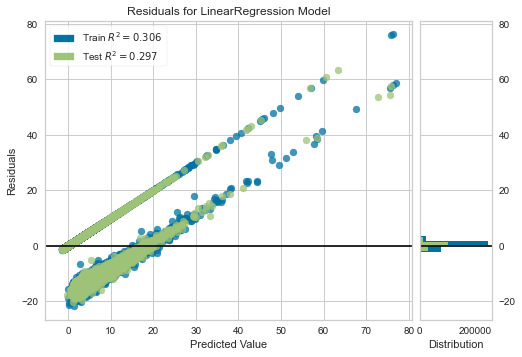

In [28]:
plot_model(lr) # write here tuned_lightgbm

## Prediction Error Plot

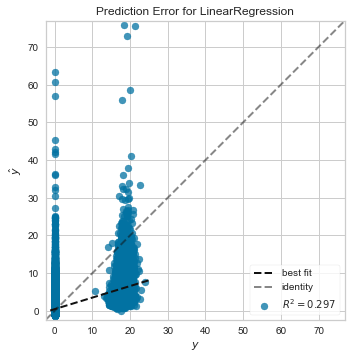

In [29]:
plot_model(lr, plot = 'error') # write here tuned_lightgbm

## Feature Importance Plot

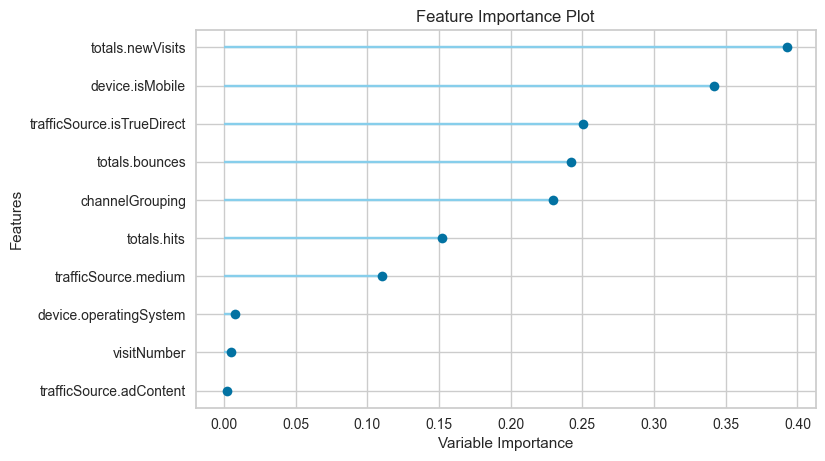

In [30]:
plot_model(lr, plot='feature') # write here tuned_lightgbm

## Predict on test / hold-out Sample

In [31]:
predict_model(lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.0870,7.4079,2.7217,0.2965,0.6121,0.6883


## Finalize Model for Deplyoment

In [32]:
final_lr = finalize_model(lr)

In [33]:
predict_model(final_lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.0818,7.4051,2.7212,0.2968,0.6093,0.6908


## Predict on unseen data

In [34]:
unseen_predictions = predict_model(final_lr, data=data_unseen)

In [35]:
check_metric(unseen_predictions["Target"], unseen_predictions.Label, 'RMSE')

4.1974

# Final part - Creating submission file

## Saving the Predicted Target Values of the Model

In [36]:
sub_reg = unseen_predictions['Label']
sub_reg.head()

0    0.189736
1    0.087735
2    0.843213
3    0.670745
4   -0.111545
Name: Label, dtype: float32

### Saving the result of prediction in CSV file

In [37]:
sub_reg.to_csv("model/sub_reg_base.csv",index=False)

### Calling back Regression Result

In [38]:
sub_reg = pd.read_csv("model/sub_reg_base.csv")

In [39]:
pred_test = sub_reg.Label

### Saving FullvisitorID for creating submission file for aggregation per Customer

In [40]:
test_id = dataset_test["fullVisitorId"].values
pred_target = pd.DataFrame({"fullVisitorId":test_id})

### This is the part to get Predict Target value with fullVisitorId

In [41]:
# Removing negative values
pred_test[pred_test<0] = 0
pred_target["PredictedLogRevenue"] = np.expm1(pred_test)
pred_target = pred_target.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()

### Submission file ready below!

In [42]:
pred_target.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_target["PredictedLogRevenue"] = np.log1p(pred_target["PredictedLogRevenue"])
pred_target.to_csv("model/submission_base.csv", index=False)

In [43]:
# Final submission file
pred_target.head()

,fullVisitorId,PredictedLogRevenue
0,1995526696366,0.150312
1,16367580689231,0.000000
2,18966949534117,0.629048
3,24844201502183,1.603574
4,24845665201193,0.026738


##  RMSE based on Stakeholders Definition

### This is the part to get Actual Target with fullVisitorId to compare the previously Predict Target

In [44]:
act_target = pd.DataFrame({"fullVisitorId":test_id})
act_target.head()

,fullVisitorId
0,7460955084541987166
1,460252456180441002
2,3461808543879602873
3,975129477712150630
4,8381672768065729990


In [45]:
act_target["Target_actual"] = np.expm1(unseen_predictions['Target'])
act_target = act_target.groupby("fullVisitorId")["Target_actual"].sum().reset_index()

In [46]:
act_target.columns = ["fullVisitorId", "Target_actual"]
act_target["Target_actual"] = np.log1p(1+act_target["Target_actual"])
act_target.head()

,fullVisitorId,Target_actual
0,1995526696366,0.693147
1,16367580689231,0.693147
2,18966949534117,0.693147
3,24844201502183,0.693147
4,24845665201193,0.693147


In [47]:
# Defining the RMSE (based on Customer level)
RMSE = np.sqrt((sum( (act_target['Target_actual'].values - pred_target['PredictedLogRevenue'].values) **2)) / len(act_target))

In [48]:
print(f'Your RMSE Score is: {RMSE}')

Your RMSE Score is: 2.0521371713467924
